In [ ]:
!nvidia-smi

Thu Dec 25 13:11:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os

Mounted at /content/drive


In [ ]:
# Copy dataset dari Drive ke local Colab
!cp -r "/content/drive/My Drive/rubber_leaf_dataset" /content/

In [ ]:
dataset_path = '/content/rubber_leaf_dataset'
if os.path.exists(dataset_path):
    print(f"Dataset ditemukan di: {dataset_path}")
    print("Isi direktori:")
    print(os.listdir(dataset_path))
else:
    print(f"PERINGATAN: Dataset tidak ditemukan di path yang ditentukan: {dataset_path}")
    print("Pastikan path sudah benar dan sesuai dengan struktur Google Drive Anda.")

Dataset ditemukan di: /content/rubber_leaf_dataset
Isi direktori:
['0', '2', '3', '1', '4']


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import glob
from pathlib import Path

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
TRAIN_SPLIT = 0.7
VALIDATION_SPLIT = 0.15
TEST_SPLIT = 0.15
RANDOM_STATE = 42
NUM_CLASSES = 5
SE_RATIO = 16

# Memastikan jumlah split sama dengan 1
assert (TRAIN_SPLIT + VALIDATION_SPLIT + TEST_SPLIT) == 1.0, "Jumlah proporsi split harus 1.0"

In [ ]:
# Mendapatkan semua path file gambar dan labelnya
image_paths = sorted(
    glob.glob(os.path.join(dataset_path, '*/*.jpg')) +
    glob.glob(os.path.join(dataset_path, '*/*.JPG'))
)
labels = [int(os.path.basename(os.path.dirname(path))) for path in image_paths]

print(f"Total gambar yang ditemukan: {len(image_paths)}")
print(f"Total label yang ditemukan: {len(labels)}")
print(f"Contoh path gambar: {image_paths}")
print(f"Contoh label: {labels}")
print(f"Jumlah kelas unik: {len(np.unique(labels))}")

Total gambar yang ditemukan: 3070
Total label yang ditemukan: 3070
Contoh path gambar: ['/content/rubber_leaf_dataset/0/20240613_115050.jpg', '/content/rubber_leaf_dataset/0/20240613_115057.jpg', '/content/rubber_leaf_dataset/0/20240613_115102.jpg', '/content/rubber_leaf_dataset/0/20240613_115108.jpg', '/content/rubber_leaf_dataset/0/20240613_115112.jpg', '/content/rubber_leaf_dataset/0/20240613_115118.jpg', '/content/rubber_leaf_dataset/0/20240613_115125.jpg', '/content/rubber_leaf_dataset/0/20240613_115129.jpg', '/content/rubber_leaf_dataset/0/20240613_115135.jpg', '/content/rubber_leaf_dataset/0/20240613_115141.jpg', '/content/rubber_leaf_dataset/0/20240613_115145.jpg', '/content/rubber_leaf_dataset/0/20240613_115149.jpg', '/content/rubber_leaf_dataset/0/20240613_115153.jpg', '/content/rubber_leaf_dataset/0/20240613_115158.jpg', '/content/rubber_leaf_dataset/0/20240613_115202.jpg', '/content/rubber_leaf_dataset/0/20240613_115207.jpg', '/content/rubber_leaf_dataset/0/20240613_115211.

In [ ]:
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths,
    labels,
    test_size=(VALIDATION_SPLIT + TEST_SPLIT),
    random_state=RANDOM_STATE,
    stratify=labels
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths,
    temp_labels,
    test_size=(TEST_SPLIT / (VALIDATION_SPLIT + TEST_SPLIT)),
    random_state=RANDOM_STATE,
    stratify=temp_labels
)

print(f"Jumlah data latih: {len(train_paths)}")
print(f"Jumlah data validasi: {len(val_paths)}")
print(f"Jumlah data uji: {len(test_paths)}")

# Verifikasi distribusi kelas di setiap set
def check_distribution(labels, name):
    unique, counts = np.unique(labels, return_counts=True)
    percentages = [f"{c/sum(counts)*100:.2f}%" for c in counts]
    print(f"\nDistribusi kelas pada set {name}:")
    print(dict(zip(unique, percentages)))

check_distribution(train_labels, "Latih")
check_distribution(val_labels, "Validasi")
check_distribution(test_labels, "Uji")

Jumlah data latih: 2149
Jumlah data validasi: 460
Jumlah data uji: 461

Distribusi kelas pada set Latih:
{np.int64(0): '20.24%', np.int64(1): '20.75%', np.int64(2): '18.94%', np.int64(3): '19.87%', np.int64(4): '20.20%'}

Distribusi kelas pada set Validasi:
{np.int64(0): '20.22%', np.int64(1): '20.65%', np.int64(2): '19.13%', np.int64(3): '19.78%', np.int64(4): '20.22%'}

Distribusi kelas pada set Uji:
{np.int64(0): '20.17%', np.int64(1): '20.82%', np.int64(2): '18.87%', np.int64(3): '19.96%', np.int64(4): '20.17%'}


In [ ]:
def parse_image(filepath, label):
    """Fungsi untuk membaca, mendekode, dan mengubah ukuran gambar."""
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    return image, label

def create_dataset(paths, labels, shuffle=False):
    """Fungsi untuk membuat objek tf.data.Dataset dari path dan label."""
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=RANDOM_STATE)

    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

# Membuat pipeline data untuk setiap set
train_ds = create_dataset(train_paths, train_labels, shuffle=True)
val_ds = create_dataset(val_paths, val_labels)
test_ds = create_dataset(test_paths, test_labels)

print("\nObjek tf.data.Dataset telah dibuat:")
print(train_ds)
print(val_ds)
print(test_ds)


Objek tf.data.Dataset telah dibuat:
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


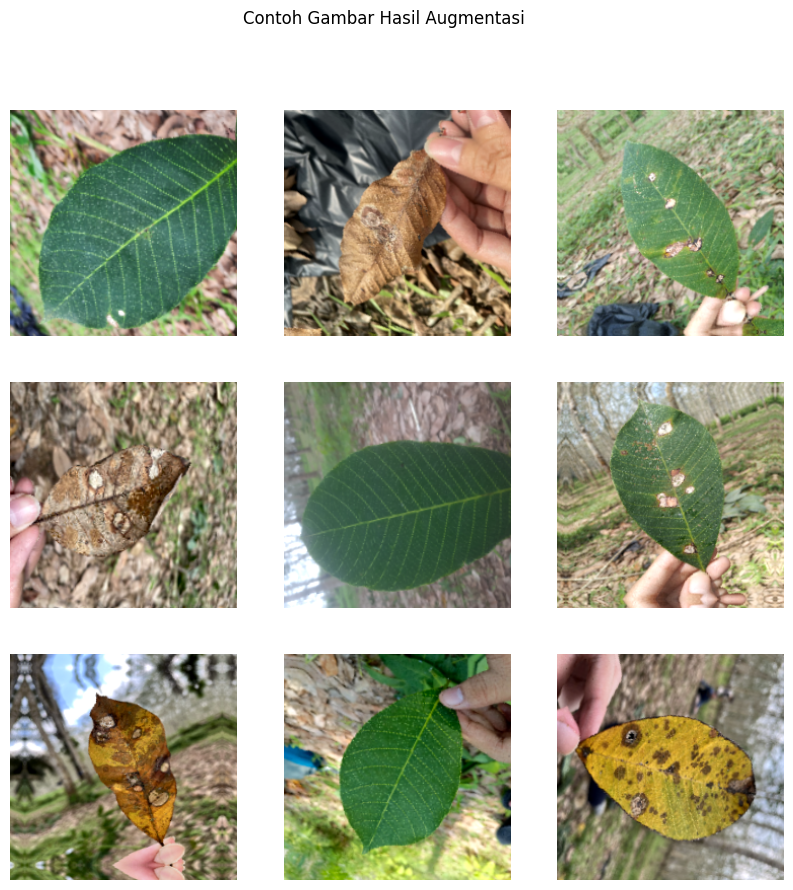

In [ ]:
 data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
    ],
    name="data_augmentation",
)

# Menerapkan augmentasi hanya pada data latih
train_ds_augmented = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Visualisasi efek augmentasi
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_image = data_augmentation(tf.expand_dims(images[i], axis=0))
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis("off")
plt.suptitle("Contoh Gambar Hasil Augmentasi")
plt.show()

In [ ]:
def se_block(input_tensor, ratio=16):
    channel_axis = -1  # Mengasumsikan format data 'channels_last'
    filters = input_tensor.shape[channel_axis]

    # Squeeze
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape((1, 1, filters))(se)

    # Excitation
    se = layers.Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se) #FC pertama
    se = layers.Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se) #FC kedua

    # Scale
    x = layers.multiply([input_tensor, se])
    return x

In [ ]:
def resnet_identity_block(input_tensor, kernel_size, filters):
    """Blok identitas ResNet dengan integrasi SE."""
    filters1, filters2, filters3 = filters

    x = layers.Conv2D(filters1, (1, 1), kernel_initializer='he_normal')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    # Integrasi SE Block di sini
    x = se_block(x, ratio=SE_RATIO)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def resnet_conv_block(input_tensor, kernel_size, filters, strides=(2, 2)):
    """Blok konvolusi ResNet dengan integrasi SE."""
    filters1, filters2, filters3 = filters

    x = layers.Conv2D(filters1, (1, 1), strides=strides, kernel_initializer='he_normal')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    # Integrasi SE Block di sini
    x = se_block(x, ratio=SE_RATIO)

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides, kernel_initializer='he_normal')(input_tensor)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [ ]:
def build_se_resnet50(input_shape, num_classes):
    img_input = layers.Input(shape=input_shape)

    # Preprocessing layer
    x = layers.Rescaling(1./255)(img_input)

    # Stage 1
    x = layers.ZeroPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='valid', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D(padding=(1, 1))(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Stage 2
    x = resnet_conv_block(x, 3, [64, 64, 256], strides=(1, 1))
    x = resnet_identity_block(x, 3, [64, 64, 256])
    x = resnet_identity_block(x, 3, [64, 64, 256])

    # Stage 3
    x = resnet_conv_block(x, 3, [128, 128, 512])
    x = resnet_identity_block(x, 3, [128, 128, 512])
    x = resnet_identity_block(x, 3, [128, 128, 512])
    x = resnet_identity_block(x, 3, [128, 128, 512])

    # Stage 4
    x = resnet_conv_block(x, 3, [256, 256, 1024])
    x = resnet_identity_block(x, 3, [256, 256, 1024])
    x = resnet_identity_block(x, 3, [256, 256, 1024])
    x = resnet_identity_block(x, 3, [256, 256, 1024])
    x = resnet_identity_block(x, 3, [256, 256, 1024])
    x = resnet_identity_block(x, 3, [256, 256, 1024])

    # Stage 5
    x = resnet_conv_block(x, 3, [512, 512, 2048])
    x = resnet_identity_block(x, 3, [512, 512, 2048])
    x = resnet_identity_block(x, 3, [512, 512, 2048])

    # Classification Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(num_classes, activation='softmax', kernel_initializer='he_normal')(x)

    model = Model(img_input, x, name='SE_ResNet50')

    # Transfer Learning: Memuat bobot dari ResNet50 pre-trained
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)
    for layer in model.layers:
        if layer.get_weights(): # Hanya jika layer memiliki bobot
            try:
                # Cari layer dengan nama yang sama di base_model
                base_layer = base_model.get_layer(name=layer.name)
                layer.set_weights(base_layer.get_weights())
            except ValueError:
                pass


    return model

# Membangun model
model = build_se_resnet50(input_shape=IMG_SIZE + (3,), num_classes=NUM_CLASSES)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "SE_ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ rescaling[0][0]   │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     16,640 │ activation_2[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ batch_normalizat

 Total params: 26,112,901 (99.61 MB)

 Trainable params: 26,059,781 (99.41 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# Menginstansiasi optimizer AdamW
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Mengompilasi model
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Mendefinisikan callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    save_best_only=True,
    monitor="val_accuracy"
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True,
    monitor="val_accuracy"
)

reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

In [ ]:
# Melatih model
history = model.fit(
    train_ds_augmented, # Menggunakan data latih yang sudah diaugmentasi
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb]
)

Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.4467 - loss: 1.4522 - val_accuracy: 0.3717 - val_loss: 2.0250 - learning_rate: 1.0000e-04
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.8267 - loss: 0.4978 - val_accuracy: 0.4435 - val_loss: 2.1138 - learning_rate: 1.0000e-04
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.8598 - loss: 0.3812 - val_accuracy: 0.5891 - val_loss: 1.1728 - learning_rate: 1.0000e-04
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.8939 - loss: 0.3301 - val_accuracy: 0.8304 - val_loss: 0.4269 - learning_rate: 1.0000e-04
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.8942 - loss: 0.2754 - val_accuracy: 0.8435 - val_loss: 0.4795 - learning_rate: 1.0000e-04
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.9282 - loss: 0.2096 - val_accuracy: 0.8826 - val_loss: 0.3953 - learning_rate: 1.0000e-04
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.9192 

In [ ]:
  # Memuat model dengan performa terbaik
best_model = tf.keras.models.load_model("best_model.keras")

In [ ]:
# Mengevaluasi model pada data uji
test_loss, test_accuracy = best_model.evaluate(test_ds)
print(f"\nHasil Evaluasi pada Data Uji:")
print(f"Loss: {test_loss:.4f}")
print(f"Akurasi: {test_accuracy:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.9520 - loss: 0.1539

Hasil Evaluasi pada Data Uji:
Loss: 0.1371
Akurasi: 0.9588


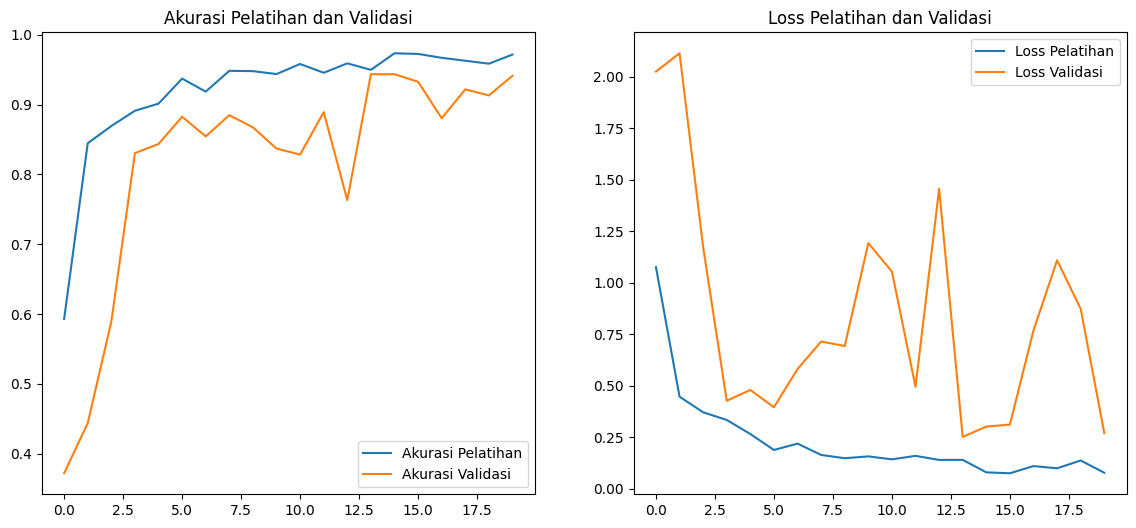

In [ ]:
# Plotting riwayat akurasi dan loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Akurasi Pelatihan')
plt.plot(epochs_range, val_acc, label='Akurasi Validasi')
plt.legend(loc='lower right')
plt.title('Akurasi Pelatihan dan Validasi')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Loss Pelatihan')
plt.plot(epochs_range, val_loss, label='Loss Validasi')
plt.legend(loc='upper right')
plt.title('Loss Pelatihan dan Validasi')
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step


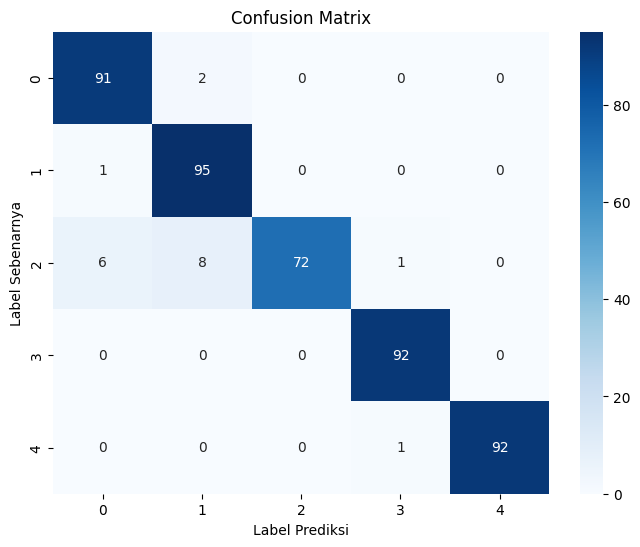


Laporan Klasifikasi Rinci:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95        93
           1       0.90      0.99      0.95        96
           2       1.00      0.83      0.91        87
           3       0.98      1.00      0.99        92
           4       1.00      0.99      0.99        93

    accuracy                           0.96       461
   macro avg       0.96      0.96      0.96       461
weighted avg       0.96      0.96      0.96       461



In [ ]:
# Menghasilkan prediksi pada data uji
y_pred_probs = best_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Mengambil label asli dari test_ds
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Menghasilkan dan memvisualisasikan Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES))
plt.xlabel('Label Prediksi')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix')
plt.show()

# Menghasilkan Laporan Klasifikasi
print("\nLaporan Klasifikasi Rinci:")
class_names = [str(i) for i in range(NUM_CLASSES)] # Define class names
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
# Simpan ulang dari variabel best_model ke format .h5
best_model.save("my_best_model.h5")

# Cek apakah file sudah muncul di folder /content
!ls -lh *.h5

-rw-r--r-- 1 root root 300M Dec 25 15:11 my_best_model.h5


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Contoh 1 gambar uji
img_path = "/content/rubber_leaf_dataset/3/IMG_6621.jpg"

img = image.load_img(img_path, target_size=(224, 224))
img = image.img_to_array(img)
img = img / 255.0
img = np.expand_dims(img, axis=0)

pred = best_model.predict(img)
pred_class = np.argmax(pred)

print("Prediksi kelas:", pred_class)
print("Probabilitas:", pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Prediksi kelas: 3
Probabilitas: [[8.7224862e-06 2.2071239e-03 9.5363669e-03 9.8805422e-01 1.9349184e-04]]
